In [1]:
import os
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", message=".*defaulting to pandas implementation.*")
pd.set_option('display.float_format', '{:.6f}'.format)

# Import Model

In [2]:
jupyter_dir = os.path.abspath(str(Path()))
jupyter_dir

'E:\\git\\machine-learning-option-pricing'

In [3]:
models_path = os.path.join(jupyter_dir,'trained_models','trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   2024_10_09 23-01-12 Deep Neural Network otm
1   2024_10_09 23-11-23 Deep Neural Network
2   2024_10_10 11-56-07 Deep Neural Network
3   2024_10_10 12-04-22 Deep Neural Network
4   2024_10_11 10-19-52 Deep Neural Network
5   2024_10_11 11-25-11 Deep Neural Network
6   2024_10_11 12-08-00 Deep Neural Network
7   2024_10_11 12-45-52 Deep Neural Network


In [4]:
model = models[7]
model

'2024_10_11 12-45-52 Deep Neural Network'

In [5]:
model_path = os.path.join(models_path,model)

In [6]:
model_files = os.listdir(model_path)
model_files

['2024_10_11 12-45-52 Deep Neural Network insample.csv',
 '2024_10_11 12-45-52 Deep Neural Network outsample.csv',
 '2024_10_11 12-45-52 Deep Neural Network.pkl',
 '2024_10_11 12-45-52 Deep Neural Network.txt']

In [7]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])

In [8]:
model_files

['2024_10_11 12-45-52 Deep Neural Network insample.csv',
 '2024_10_11 12-45-52 Deep Neural Network outsample.csv',
 '2024_10_11 12-45-52 Deep Neural Network.pkl',
 '2024_10_11 12-45-52 Deep Neural Network.txt']

In [9]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]
outsample

2024-10-11 15:22:45,004	INFO worker.py:1786 -- Started a local Ray instance.


,calculation_date,spot_price,strike_price,barrier,days_to_maturity,barrier_price,updown,outin,w,barrier_type_name,...,kappa,rho,eta,v0,expiration_date,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
0,2008-06-26,1283.570000,1155.213000,641.785000,60,8.333303,Down,Out,put,DownOut,...,1.421590,-1.000000,0.169391,0.051732,2008-08-25,-0.948062,8.496853,8.496853,4.940286,-3.556568
1,2008-06-26,1283.570000,1155.213000,641.785000,90,14.450123,Down,Out,put,DownOut,...,1.421590,-1.000000,0.169391,0.051732,2008-09-24,-0.922092,14.277631,14.277631,5.527019,-8.750612
2,2008-06-26,1283.570000,1155.213000,641.785000,90,0.000114,Down,In,put,DownIn,...,1.421590,-1.000000,0.169391,0.051732,2008-09-24,-0.922092,0.407132,0.407132,5.276474,4.869342
3,2008-06-26,1283.570000,1155.213000,641.785000,180,29.783522,Down,Out,put,DownOut,...,1.421590,-1.000000,0.169391,0.051732,2008-12-23,-0.844185,29.735953,29.735953,19.042632,-10.693322
4,2008-06-26,1283.570000,1155.213000,641.785000,180,0.601677,Down,In,put,DownIn,...,1.421590,-1.000000,0.169391,0.051732,2008-12-23,-0.844185,0.799405,0.799405,9.388062,8.588657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913080,2008-09-26,1214.590000,1336.049000,1821.885000,360,41.074382,Up,In,call,UpIn,...,10.371795,-0.400391,0.901972,0.148215,2009-09-21,2.711247,41.267661,41.267661,66.402945,25.135284
913081,2008-09-26,1214.590000,1336.049000,1821.885000,540,34.759713,Up,Out,call,UpOut,...,10.371795,-0.400391,0.901972,0.148215,2010-03-20,1.474165,34.835709,34.835709,32.007070,-2.828638
913082,2008-09-26,1214.590000,1336.049000,1821.885000,540,75.538637,Up,In,call,UpIn,...,10.371795,-0.400391,0.901972,0.148215,2010-03-20,1.474165,75.739054,75.739054,118.250957,42.511903
913083,2008-09-26,1214.590000,1336.049000,1821.885000,720,28.078404,Up,Out,call,UpOut,...,10.371795,-0.400391,0.901972,0.148215,2010-09-16,0.855624,27.885024,27.885024,28.650350,0.765325


# Test Model

In [10]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n     maturities = {maturities}")
print(f"\ntypes:\n     barrier_type_names = {barrier_type_names}\n     ws = {ws}\n")


maturities:
     maturities = [60, 90, 180, 360, 540, 720]

types:
     barrier_type_names = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
     ws = ['put', 'call']



In [11]:
by_wbt = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity']).sort_index()

In [12]:
RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    columns = barrier_type_names,
    index = maturities
)

for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


RMSE:
      DownOut    DownIn     UpOut      UpIn
60  14.464611 14.128014 15.480705 17.892786
90  13.411065 12.356520 12.897013 16.261613
180 14.465497 12.516362 11.576552 15.133375
360 14.285705 13.114471 10.551158 14.992325
540 13.917252 13.824221 10.457383 14.569312
720 14.729111 16.942909 11.628011 12.237543


In [13]:
MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


MAE:
      DownOut    DownIn     UpOut      UpIn
60   8.839602  8.984878 11.286540 10.667579
90   8.099856  7.428498  8.875588  9.300975
180  9.357800  7.874801  7.970261  8.553640
360  8.917415  8.109636  7.344790  9.163510
540  8.906035  8.457959  6.927285  9.689336
720 10.057571 10.703680  8.126924  9.337396


In [14]:
MAE

,DownOut,DownIn,UpOut,UpIn
60,8.839602,8.984878,11.286540,10.667579
90,8.099856,7.428498,8.875588,9.300975
180,9.357800,7.874801,7.970261,8.553640
360,8.917415,8.109636,7.344790,9.163510
540,8.906035,8.457959,6.927285,9.689336
720,10.057571,10.703680,8.126924,9.337396


In [15]:
errors_bypayoff = {}
for w in ws:
    errors = {}
    print(
        f"\n         {'#'*(len(w)+5)}"
        f"\n         # {w}s #"
        f"\n         {'#'*(len(w)+5)}"
    )
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
        )
    RMSE[w] = maturities
    RMSE = RMSE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(w, b, t),'outofsample_error'])**2))
    print(f"RMSE:\n{RMSE}")
    print()
    errors['RMSE'] = RMSE
    


    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
    )
    MAE[w] = maturities
    MAE = MAE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(w, b, t),'outofsample_error']))
    print(f"MAE:\n{MAE}")
    print()
    errors['MAE'] = MAE
    errors_bypayoff[w] = errors


         ########
         # puts #
         ########
RMSE:
      DownOut    DownIn     UpOut      UpIn
put                                        
60  12.039250 17.669908 16.367519 13.842776
90   9.247909 15.369560 14.768029 12.824167
180  9.839677 15.790292 13.974619 12.290799
360  9.561107 17.239101 13.125419 12.384195
540  8.518274 17.871992 13.302676 11.220778
720 10.360973 20.626447 14.620890 10.102537

MAE:
     DownOut    DownIn     UpOut     UpIn
put                                      
60  9.346600 11.707462 11.204323 7.016355
90  6.870979  9.164596 10.056196 6.285447
180 7.684554 10.075869  9.847285 5.708505
360 7.111389 11.444895  9.445869 6.295932
540 5.465944 11.587998  9.335758 6.743239
720 6.759296 13.970801 10.505010 6.985419


         #########
         # calls #
         #########
RMSE:
       DownOut    DownIn     UpOut      UpIn
call                                        
60   16.358255  8.153145 14.441160 21.197449
90   16.294504  7.632583 10.455939 19.193996


In [16]:
max_MAE = max(errors['MAE'].values.flatten())
max_RMSE = max(errors['RMSE'].values.flatten())
plot_height = max(max_RMSE,max_MAE)*1.05
maturities = errors['MAE'].index.astype(str).tolist()

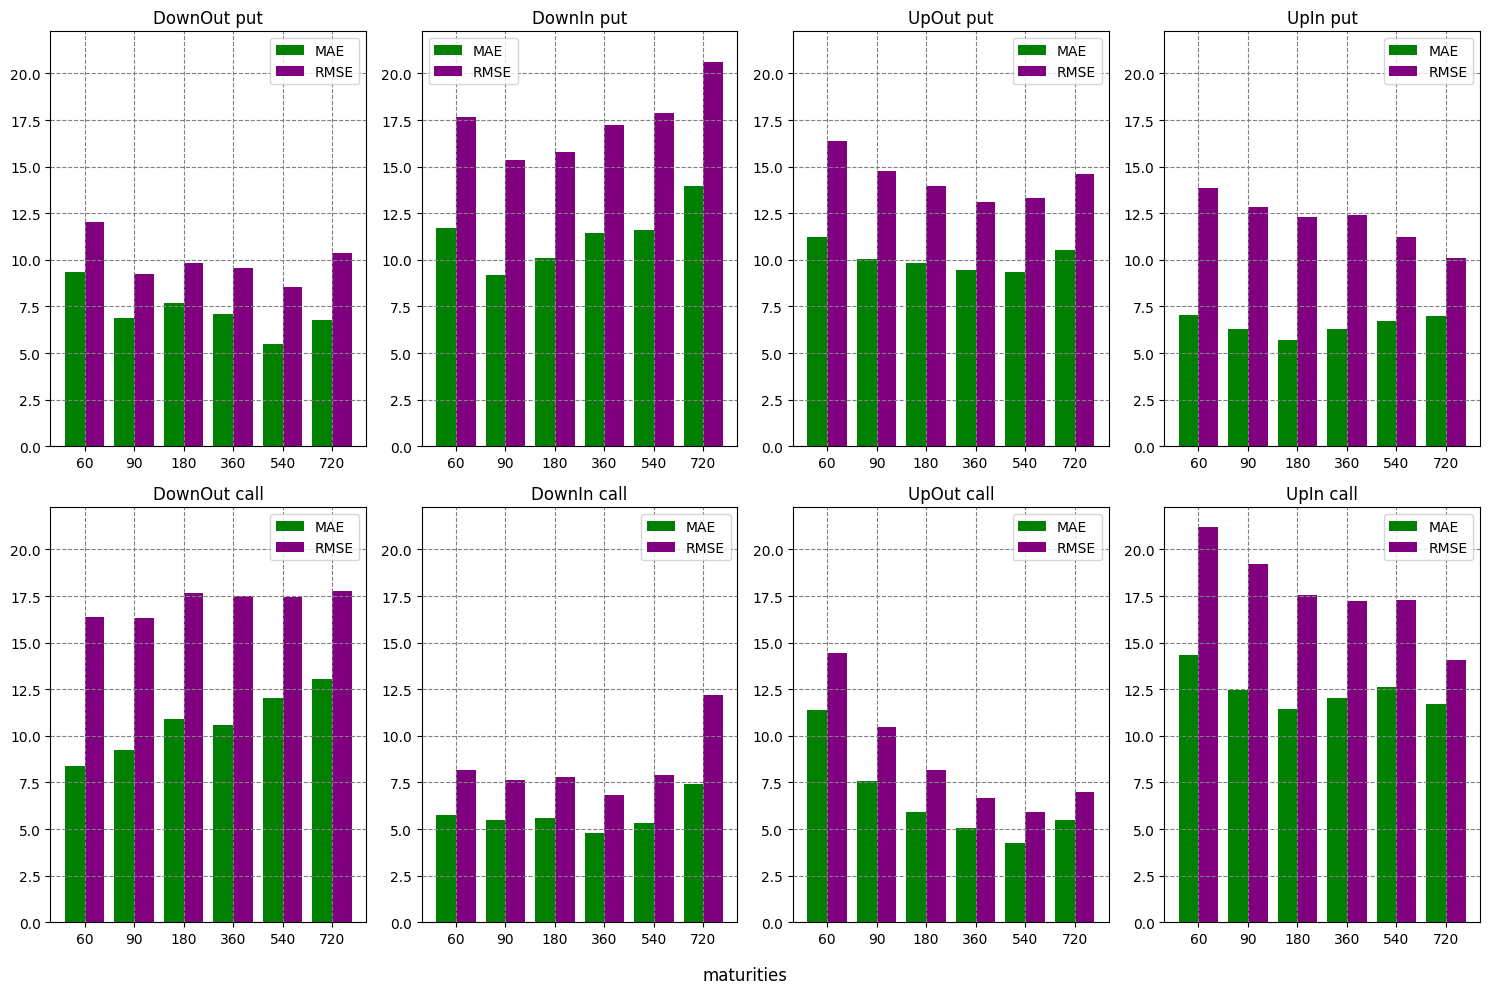

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
bar_width = 0.4
i = 0
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names:

        MAE = errors['MAE'][b]
        RMSE = errors['RMSE'][b]
        x_positions = range(len(maturities))
        axs[i // 4, i % 4].grid(True,which='both', linestyle='--', color='gray')
        axs[i // 4, i % 4].bar(
            [x - 0.5 * bar_width for x in x_positions], MAE, width=bar_width, color='green',label="MAE"
        )
        
        axs[i // 4, i % 4].bar(
            [x + 0.5 * bar_width for x in x_positions], RMSE, width=bar_width, color='purple', label="RMSE"
        )
        axs[i // 4, i % 4].set_title(f'{b} {w}')
        axs[i // 4, i % 4].set_xticks(x_positions)
        axs[i // 4, i % 4].set_xticklabels(maturities)
        axs[i // 4, i % 4].set_ylim(0, plot_height)
        axs[i // 4, i % 4].legend()
        i += 1

fig.supxlabel('maturities')

plt.tight_layout()
plt.show()